# Neural network with integrate and fire neurons

We have already seen Hodgkin-Huxley's model of spiking in the squid giant axon. This is a rather complex model. Researchers often simplify the spiking neuron as an integrate and fire (IF) neuron.

In the exercise 3 in the [Synapses](./Synapses.ipynb) notebook you may have noticed that when two spikes arrive at the synapse close together in time, their effects add up. When spikes arrive simultaneously at multiple synapses, their effect also add up similarly. When the EPSP goes above the threshold for spiking, the neuron generates a spike. To mimic this, we can have a neuron model which adds up its input, and fires an action potential whenever the voltage goes above threshold.

The integrate and fire model implements this by adding the inputs to its current voltage which keeps decaying with a time constant. When the voltage crosses the threshold, the neuron generates a spike and its voltage is reset to a small value. Also, neurons need some minimum time to recover after a spike, which is a refractory period. Once an IF neuron spikes, it cannot fire another spike within this time. 

In [9]:
# imports

import numpy as np
import matplotlib.pyplot as plt

import moose


In [10]:
# containers
if moose.exists('/sim'):
    moose.delete('/sim')
    
sim = moose.Neutral('/sim')
model = moose.Neutral(f'{sim.path}/model')
data = moose.Neutral(f'{sim.path}/data')

## Creating a single integrate and fire neuron with random input

The `IntFire` class in MOOSE implements a simple integrate and fire neuron. Like `Compartment`, it has a `Vm` field which is an abstraction of the membrane voltage of a real neuron. Below we create a single IF neuron called `neuronA` and attach a table `vmA` to record its `Vm`.

In [29]:
# Create a simple integrate and fire neuron
neuronA = moose.IntFire(f'{model.path}/neuronA')

In [17]:
vmA = moose.Table(f'{data.path}/VmA')
moose.connect(vmA, 'requestOut', neuronA, 'getVm')

<moose.SingleMsg id=5 dataIndex=3 path=/Msgs[0]/singleMsg[3]>

Next, we create a `SimpleSynHandler` object to handle incoming spikes and pass the activation to the IG neuron.

In [12]:
# Handler for synaptic input
synh = moose.SimpleSynHandler(f'{neuronA.path}/synh')
synh.synapse.num = 1   # for a starter have just one synapse

In [13]:
# Connect the activation output of the SynHandler to the activation input of the IntFire neuron
moose.connect(synh, 'activationOut', neuronA, 'activation')

<moose.SingleMsg id=5 dataIndex=1 path=/Msgs[0]/singleMsg[1]>

For generating spikes, we shall use a random spike generator (`RandSpike`) in this test. A `RandSpike` generates spikes at random times at a specified rate. Thus, the probability of a spike in $dt$ time interval is $rate * dt$. This also has a refractory period, `refractT`, and after generating a spike it will not produce a second spike with that time, irrespective of $rate$ and $dt$.

In [14]:
# Create and connect a spike generator to deliver spike events to the `SynChan`
spikegen = moose.RandSpike(f'{model.path}/spike')
moose.connect(spikegen, 'spikeOut', synh.synapse[0], 'addSpike')

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

In [26]:
spikegen.refractT = 5e-3
spikegen.rate = 100    # 100 Hz rate

neuronA.thresh = 10e-3  # firing threshold
neuronA.tau = 1e-3   # time constant for voltage decay

synh.synapse[0].weight = 1.0
synh.synapse[0].delay = 0

In [27]:
runtime = 200e-3

moose.seed(0)
moose.reinit()
moose.start(runtime)

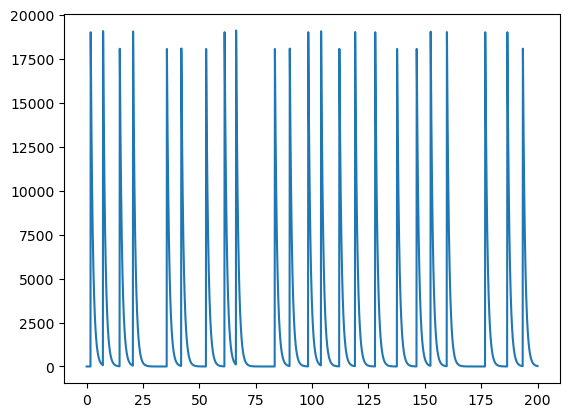

In [28]:
t = np.arange(len(vmA.vector)) * vmA.dt
plt.plot(t * 1e3, vmA.vector)